# INTRODUCTION - DeviceBERT: Using Enriched Named Entity Recognition to Identify Medical Device Terminology in Device Recalls Data.

This notebook provides the code needed to prepare the data, train and implement DeviceBERT, a language model based on BioBERT, which is trained and finetuned to perform entity recognition of Medical Device terms.

To prepare and train DeviceBERT, we create an enriched, BERT tokenizer, which is augmented with medical device vocabulary, curated from various Open FDA datasets. The BioBERT model is trained on a annotated corpus of Medical Device Recalls data, which is annotated in BIO format utiling Doccano.

The Datasets and Model created from this project have been made available on Huggingface hub for use in further training and inferencing tasks:

* **DeviceBERT Model Card:** https://huggingface.co/mfarrington/device_recalls_ner_model \
* **NER Recalls Training Dataset:** https://huggingface.co/mfarrington/biobert-ner-fda-recalls-dataset
* **Enriched DeviceBERT Tokenizer:** https://huggingface.co/mfarrington/DeviceBERT-tokenizer

**Background**: This project was created as a student final project for Stanford CS224N: Natural Language Proecessing with Deep Learning. In this project, we demonstrate that the challenges inherint in sub-domain specific NER tasks can be alleviated through an enriched approach to data preparation, tokenization and regularization techniques.

**Paper:** *DeviceBERT: Addressing Domain-Specific Learning Challenges Using Vocabulary Enrichment to Identify Medical Device Terminology in FDA Recall Action Summaries*

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
from google.colab import userdata

In [3]:
#Install additional dependencies
!pip install datasets
!pip install seqeval
!pip install evaluate
!pip install accelerate -U
!pip install huggingface_hub
!pip install transformers
!pip install nltk

In [4]:
import pandas as pd
import numpy as np
import random
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
import json
import re
import torch
from tqdm import tqdm
import tabulate as tb
from datasets import load_dataset, Dataset, load_metric
import evaluate
from transformers import (AutoModelForTokenClassification,
                          AutoTokenizer,
                          TrainingArguments,
                          DataCollatorForTokenClassification,
                          Trainer,
                          AdamW,
                          BertTokenizer,
                          BertForTokenClassification,
                          BertModel)
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
#copy the device recalls and annotation file to the working directory
!cp drive/MyDrive/Stanford/annotated-2000.jsonl .
!cp drive/MyDrive/Stanford/device-recall-0001-of-0001.json .
!cp drive/MyDrive/Stanford/foiclass.txt .

#PART 1 - Preparing, Transforming and Tokenizing the Device Recalls Dataset

This part of the notebook performs the data preparation, cleaning, tokenization and alignment for the NER dataset used to train the BioBERT model, which is created in Doccano. The dataset is created utilizing 2000 Device Recall actions annotated with NER tags for device recognition (B-DEVICE, I-DEVICE, O-DEVICE).To peform these steps you will need to extract the device recalls and device classification datasets from OpenFDA (https://open.fda.gov/data/) to your working directory.

Note: Data Annotation is a separate step that is performed in advance. To run this section of the notebook, you will need the original jsonl annotation file ('annotated-2000.jsonl'). Doccano is an open-source device annotation tool used to perform the NER annotations.To view the original annotations, or perform addtional annotations on the data, you can install and run doccano using the instructions here: https://doccano.github.io/doccano/.

In [6]:
# Load the JSON Recalls data
with open('device-recall-0001-of-0001.json') as f:
  data = json.load(f)

# Load the foiclass text data into a dataframe
foi_df = pd.read_csv('foiclass.txt', sep='|', header=0, encoding='latin1')
foi_df = foi_df[['DEVICENAME']].rename(columns={'DEVICENAME': 'device-name-foiclass'})

In [7]:
# Extract the device recall identifier and relevant fields
cfres_id = []
device_name = []
product_description = []
recall_action = []

rows = []
for result in data['results']:
    device_name = result.get('openfda', {}).get('device_name', None)
    recall_action = result.get('action', None)
    product_description = result.get('product_description', None)
    if device_name is not None:
        device_name = re.sub(r'[^a-zA-Z0-9\s]', '', device_name)  # Remove special characters
    if recall_action is not None:
        recall_action = re.sub(r'[^a-zA-Z0-9\s]', '', recall_action)  # Remove special characters
    if product_description is not None:
        product_description = re.sub(r'[^a-zA-Z0-9\s]', '', product_description)  # Remove special characters

    row = {
        'id': result.get('cfres_id'),
        'device_name': device_name,
        'product_description': product_description,
        'recall_action': recall_action
    }
    rows.append(row)

# Create a dataframe and clean up special characters and extra spaces
df = pd.DataFrame(rows)
df = df.apply(lambda x: x.str.replace('\n', ''))
df = df.applymap(lambda x: ' '.join(x.split()) if isinstance(x, str) else x)
print (df.size)

#Break out each object into a dataframe and remove NAs
device_df = df[['id', 'device_name']].dropna(subset=['device_name'])
product_df = df[['id', 'product_description']].dropna(subset=['product_description'])
recall_df = df[['id', 'recall_action']].dropna(subset=['recall_action'])
foi_df = foi_df.dropna(subset=['device-name-foiclass'])

#Remove duplicates entries on the text columns
device_df = device_df.drop_duplicates(subset=['device_name'])
product_df = product_df.drop_duplicates(subset=['product_description'])
recall_df = recall_df.drop_duplicates(subset=['recall_action'])
foi_df = foi_df.drop_duplicates(subset=['device-name-foiclass'])

207684


In [8]:
#Tokenize each column into words
device_df['tokens'] = device_df['device_name'].apply(word_tokenize)
product_df['tokens'] = product_df['product_description'].apply(word_tokenize)
recall_df['tokens'] = recall_df['recall_action'].apply(word_tokenize)
foi_df['tokens'] = foi_df['device-name-foiclass'].apply(word_tokenize)

# Obtain dataset sizes
print (f'Device Names: {device_df.size}')
print (f'Product Descriptions: {product_df.size}')
print (f'Device Recall Actions: {recall_df.size}')
print (f'Device Classifications: {foi_df.size}')

Device Names: 7551
Product Descriptions: 153120
Device Recall Actions: 60462
Device Classifications: 13812


In [9]:
# Merge the product and recall tokens, we'll remove values which are purely numeric from the vocab
token_df = pd.concat([device_df, product_df, recall_df, foi_df], ignore_index=True)
token_df = token_df[['tokens']]
token_df['tokens'] = token_df['tokens'].astype(str)
token_df = token_df[~token_df['tokens'].str.match('^[0-9]+$')]

token_df = token_df.drop_duplicates(subset=['tokens'])


#shuffle the tokens, convert to list and remove duplicate tokens
token_vocab = token_df['tokens'].tolist()

flattened_token_vocab = [item.strip("[]'") for sublist in token_vocab for item in sublist.split("', '")]

print('BEFORE processing', len(flattened_token_vocab))
flattened_token_vocab = list(set(flattened_token_vocab)) #remove duplicate tokens
random.shuffle(flattened_token_vocab)
vocab_list = [element for element in flattened_token_vocab if not element.isdigit()]
print('AFTER Processing', len(vocab_list))

BEFORE processing 4034870
AFTER Processing 172822


#Extract and Pre-Process the Annotated Device Recalls Data
In this step we load in the training data which has been previously annotated using Doccano with the BIO (Beginning, Inside, Outside) tags for medical devices (B-DEVICE, I-DEVICE, O-DEVICE) We perform validations to ensure the data contains no duplicate rows, and is formatted in the correct schema. We'll also drop the unneeded 'comments' column, which is used by Doccano. To perform this step, you will need the dataset 'annotated-2000.jsonl' in your project path.

In [10]:
filename = 'annotated-2000.jsonl'

# Define the dataframe schema
schema = {
    'id': str,
    'text': str,
    'Comments': str,
    'label': object  # will hold a list of lists with the label info
}

# Load the JSONL data into a DataFrame
df = pd.read_json(filename, lines=True, orient='records', dtype=schema)

# Convert the 'label' JSONL column to a list of lists
df['label'] = df['label'].apply(lambda x: [tuple(l) for l in x])

In [11]:
df = df.drop('Comments', axis=1, errors='ignore')
df = df.drop_duplicates(subset=['text'])
print(tb.tabulate(df.head(5), headers='keys', tablefmt='psql'))

+----+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------

# Transform the tokenized data to a Dataset and apply NER Labels
In this step the dataframe is transformed into a Huggingface Dataset which is tokenized, re-indexed to identify the label spans and add in the NER tags.

In [12]:
def transform_dataframe_to_dataset(df):
    dataset_dict = {
        "id": [],
        "ner_tags": [],
        "tokens": []
    }

    for index, row in df.iterrows():
        # Add id
        dataset_dict["id"].append(row["id"])

        # Tokenize text
        tokens = row["text"].split()

        # Initialize NER tags
        ner_tags = ["O"] * len(tokens)

        # Process labels
        for label in row["label"]:
            start, end, tag = label
            # Find token indices corresponding to label spans
            start_token_idx = None
            end_token_idx = None
            for i, token in enumerate(tokens):
                if start >= len(" ".join(tokens[:i])):
                    start_token_idx = i
                if end <= len(" ".join(tokens[:i + 1])):
                    end_token_idx = i + 1
                    break
            # Update NER tags with NER tag labels
            if start_token_idx is not None and end_token_idx is not None:
                ner_tags[start_token_idx] = f"{tag}"
                for i in range(start_token_idx + 1, end_token_idx):
                    ner_tags[i] = f"{tag}"

        dataset_dict["tokens"].append(tokens)
        dataset_dict["ner_tags"].append(ner_tags)

    return Dataset.from_dict(dataset_dict)

In [13]:
dataset = transform_dataframe_to_dataset(df) #create the dataset

# Perform the label to ID mapping
In this step the NER labels are mapped to a correspondin numerical id, and mapped to the dataset using the existing label locations in the ner_tags element.

In [14]:
# create a map of the expected ids to their labels
id2label = {
    0: 'O-DEVICE',
    1: 'B-DEVICE',
    2: 'I-DEVICE',
    -100: 'O',}

# create a map of the expected labels to their ids
label2id = {
    'O-DEVICE': 0,
    'B-DEVICE': 1,
    'I-DEVICE': 2,
    'O': -100,}

In [15]:
def transform_labels(dataset):
    new_labels = []
    labels = []
    for i in range(len(dataset["ner_tags"])):
       new_label = label2id.get(dataset["ner_tags"][i], -100)
       old_label = id2label.get(new_label, 'O')
       labels.append(old_label)
       new_labels.append(new_label)
    return {"ner_tags": new_labels, "labels": labels}

# map string labels to IDs
dataset = dataset.map(transform_labels)

Map:   0%|          | 0/2008 [00:00<?, ? examples/s]

# Create a Train/Test Split of the Dataset
In this example we create a 80/20 Train/Test split of the Dataset.

In [16]:
dataset = dataset.train_test_split(test_size=0.2, shuffle=True, ) #split the dataset into train and test sets

#Optional - Push Dataset to Hub
In this step we use the huggingface cli to push the updated dataset to the HuggingFace hub, making it easier to use in downstream tasks.

In [ ]:
!huggingface-cli login #enter token when prompted

In [21]:
#uncomment to push the datset to the hub
dataset.push_to_hub("mfarrington/biobert-ner-fda-recalls-dataset")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/3.28k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/mfarrington/biobert-ner-fda-recalls-dataset/commit/18626521365ea2795bcd2844b1ff33dd327ae137', commit_message='Upload dataset', commit_description='', oid='18626521365ea2795bcd2844b1ff33dd327ae137', pr_url=None, pr_revision=None, pr_num=None)

#Load the FDA Recalls NER Dataset from Huggingface Hub
In this step we load the latest version of the recalls NER dataset created in the earlier process from the hub.

In [17]:
#load the dataset
hub_dataset = load_dataset("mfarrington/biobert-ner-fda-recalls-dataset")

#Tokenize data using BERT Tokenizer and align the NER Labels
In this step, we'll use a pretrained DistilBERT tokenizer to tokenize the recalls data and evaluate how the tokenizer tokenizes medical device terminology



In [18]:
# Load DistilBERT baseline tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-cased", use_fast=True)

### In this step we test the tokenizer before expanding its vocabulary to observe how it resorts to sub-word tokenization of medical device terms
As can be seen from the example, the tokenizer performs poorly on words not in its vocabulary; the tokenizer resorts to converting the device terms to a series of sub-word tokens.


In [19]:
#Tokenize device terms
print(tokenizer.tokenize('Colonoscope'))
print(tokenizer.tokenize('Thoracolumbosacral'))
print(tokenizer.tokenize('Rhinoanemometer'))

['Col', '##ono', '##scope']
['Thor', '##aco', '##lum', '##bos', '##ac', '##ral']
['R', '##hino', '##ane', '##mo', '##meter']


# Enhance BERT Tokenizer Vocabulary to include Medical Device terminology
In this section, we utilize the corpus of medical device terms extracted and prepared earlier to enrich the tokenizer's vocabulary. We perform experiments with different percentage splits of vocabulary data (100, 50, 25) to identify the best number of tokens to perform optimal tokenization.

In [20]:
#Create vocabulary set splits of 100%, 50%, 25%
midpoint = len(vocab_list) // 2
vocab_list_50 = vocab_list[:midpoint]
random.shuffle(vocab_list_50)
midpoint = len(vocab_list_50) // 2
vocab_list_25 = vocab_list_50[:midpoint]

print(len(vocab_list))
print(len(vocab_list_50))
print(len(vocab_list_25))


print("[BEFORE] ] tokenizer vocab size:", len(tokenizer))
added_tokens = tokenizer.add_tokens(vocab_list)
print("[ AFTER ] tokenizer vocab size:", len(tokenizer))
print('added_tokens:',added_tokens)

172822
86411
43205
[BEFORE] ] tokenizer vocab size: 28996
[ AFTER ] tokenizer vocab size: 191049
added_tokens: 172821


### Re-apply tokenization to the sample Device term
The tokenizer now recognizes the terms and tokenizes them as a single word.

In [21]:
#Verify the device terms are tokenized without subwords
print(tokenizer.tokenize('Colonoscope'))
print(tokenizer.tokenize('Thoracolumbosacral'))
print(tokenizer.tokenize('Rhinoanemometer'))

['Colonoscope']
['Thoracolumbosacral']
['Rhinoanemometer']


### Optional: Uncomment to push the vocabulary enriched tokenizer to hub

In [27]:
#tokenizer.save_pretrained('devicebert-tokenizer')
#tokenizer.push_to_hub('devicebert-tokenizer')

#Realign the NER Labels and Tokens
Because the BERT tokenizer applies subword tokenization and special labels to the data, we need to realign the NER tags and BIO labels to ensure they accurately span the tokenized data. We also apply truncation to max lenght of the tokenizer model, in this case 512.

In [22]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    ner_tags = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["ner_tags"] = labels
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [23]:
tokenized_dataset = hub_dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/1606 [00:00<?, ? examples/s]

Map:   0%|          | 0/402 [00:00<?, ? examples/s]

In [24]:
#Map the Label text values back to the dataset - Optional
def map_labels(example):
    labels = example['labels']
    mapped_labels = [id2label.get(label, 'O') for label in labels]
    example['labels'] = mapped_labels
    return example

final_dataset = tokenized_dataset.map(map_labels)

Map:   0%|          | 0/1606 [00:00<?, ? examples/s]

Map:   0%|          | 0/402 [00:00<?, ? examples/s]

# PART 2 - Training, Finetuning, Regularizing and Evaluating the Model on the Annotated NER Dataset

This section of the notebook performs the model training, and finetuning. To establish a baseline metric, we start with a BERT and BioBert Base Cased  transformers:

* BERT: https://huggingface.co/google-bert/bert-base-cased
* BioBERT: https://huggingface.co/dmis-lab/biobert-base-cased-v1.2

Because of the relative small size of the Dataset (~2000 recall records), the baseline model tends to overfit on the training set. Therefore, we take additional steps to mitigate overfitting through the application of several regularization techniques. After training and evaluating the model performance to achieve acceptable results, the model is saved to the Hub and we can move on to Part 3 - Inferencing using the pretrained saved model.

The Datasets and Model created from this project have been made available on Huggingface hub for use in further training and inferencing tasks.

**Huggingface Model Card:** https://huggingface.co/mfarrington/device_recalls_ner_model. \
**NER Recalls Training Dataset:** https://huggingface.co/mfarrington/biobert-ner-fda-recalls-dataset

## Define a function to compute the model scores

In [25]:
label_list = list(id2label.values()) #Extract the device labels

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)

    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }


## Train and Finetune BioBERT on the Enhanced Vocabulary, with Regularization techniques.

In [26]:
#Initialize the evaluator
seqeval = evaluate.load("seqeval")

In [27]:
#Initialize the data collator
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [28]:
#Initialized biobert base cased model
deviceBERT_train_model = BertForTokenClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.2",
    num_labels=4,
    id2label=id2label,
    label2id=label2id,
    )

#Resize the model based on the length of the BERT tokenizer after adding the new device vocabulary
deviceBERT_train_model.resize_token_embeddings(len(tokenizer))

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Embedding(191049, 768)

# Apply dropout to BERT embeddings and encoding layer with prob = 0.2

In [39]:
import torch.nn as nn
dropout_prob = 0.2

#Regularization - applying dropout to the BERT embeddings layer
deviceBERT_train_model.bert.embeddings.dropout = nn.Dropout(dropout_prob)

#Regularization - applying dropout to the BERT encoding layer
deviceBERT_train_model.bert.encoder.dropout = nn.Dropout(dropout_prob)

In [29]:
training_args = TrainingArguments(
    output_dir="devicebert-base-cased-v1.0",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
    bf16=True,
)

In [30]:
# Define the optimizer - Optional
optimizer = AdamW(deviceBERT_train_model.parameters(), lr=training_args.learning_rate)

### Perform Cross-Validation

In [31]:
from sklearn.model_selection import KFold

# Use KFold for cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Store results for each fold
all_results = []


for train_index, val_index in kf.split(tokenized_dataset['train']):
    train_subsampler = Dataset.from_dict(tokenized_dataset['train'][train_index])
    val_subsampler = Dataset.from_dict(tokenized_dataset['train'][val_index])

    trainer = Trainer(
        model=deviceBERT_train_model,
        args=training_args,
        train_dataset=train_subsampler,
        eval_dataset=val_subsampler,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        #optimizers=(optimizer, None) #uncomment to use a specific optimizer
    )

    trainer.train()

    results = trainer.evaluate()
    all_results.append(results)

# Aggregate results
avg_precision = np.mean([result['eval_precision'] for result in all_results])
avg_recall = np.mean([result['eval_recall'] for result in all_results])
avg_f1 = np.mean([result['eval_f1'] for result in all_results])
avg_accuracy = np.mean([result['eval_accuracy'] for result in all_results])

print(f" Average Precision: {avg_precision}")
print(f" Average Recall: {avg_recall}")
print(f" Average F1: {avg_f1}")
print(f" Average Accuracy: {avg_accuracy}")

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,nan,0.472477,0.479070,0.475751,0.734279
2,No log,nan,0.579208,0.544186,0.561151,0.782984
3,No log,nan,0.542582,0.612403,0.575382,0.786683
4,No log,nan,0.589474,0.607752,0.598473,0.804562
5,No log,nan,0.649123,0.573643,0.609053,0.818126
6,No log,nan,0.576538,0.624806,0.599702,0.807028
7,0.359800,nan,0.619874,0.609302,0.614543,0.818742
8,0.359800,nan,0.608764,0.603101,0.605919,0.815660
9,0.359800,nan,0.625000,0.620155,0.622568,0.821208
10,0.359800,nan,0.622465,0.618605,0.620529,0.821208


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.452357,0.625821,0.551060,0.586066,0.830076
2,No log,0.434701,0.660417,0.610790,0.634635,0.847069
3,No log,0.451300,0.690678,0.628131,0.657921,0.854715
4,No log,0.511603,0.685022,0.599229,0.639260,0.847069
5,No log,0.566570,0.686230,0.585742,0.632017,0.847918
6,No log,0.553432,0.694143,0.616570,0.653061,0.856415
7,0.275200,0.582727,0.691974,0.614644,0.651020,0.855565
8,0.275200,0.619189,0.694093,0.633911,0.662638,0.858114
9,0.275200,0.627321,0.695560,0.633911,0.663306,0.859813
10,0.275200,0.631682,0.701053,0.641618,0.670020,0.861512


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,nan,0.790419,0.768932,0.779528,0.900855
2,No log,nan,0.784158,0.768932,0.776471,0.900000
3,No log,nan,0.781496,0.770874,0.776149,0.899145
4,No log,nan,0.752294,0.796117,0.773585,0.890598
5,No log,nan,0.756144,0.776699,0.766284,0.889744
6,No log,nan,0.775591,0.765049,0.770283,0.895726
7,0.183900,nan,0.760618,0.765049,0.762827,0.888889
8,0.183900,nan,0.751894,0.770874,0.761266,0.888034
9,0.183900,nan,0.766990,0.766990,0.766990,0.892308
10,0.183900,nan,0.754789,0.765049,0.759884,0.888889


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.195777,0.808463,0.848131,0.827822,0.920039
2,No log,0.157968,0.868932,0.836449,0.852381,0.940770
3,No log,0.166970,0.866822,0.866822,0.866822,0.937808
4,No log,0.181209,0.875000,0.834112,0.854067,0.940770
5,No log,0.188975,0.864078,0.831776,0.847619,0.933860
6,No log,0.215307,0.825397,0.850467,0.837745,0.930898
7,0.161900,0.210006,0.856471,0.850467,0.853458,0.935834
8,0.161900,0.229054,0.864734,0.836449,0.850356,0.939783
9,0.161900,0.232094,0.867299,0.855140,0.861176,0.938796
10,0.161900,0.233094,0.863529,0.857477,0.860492,0.937808


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,nan,0.931298,0.910448,0.920755,0.967199
2,No log,nan,0.940840,0.919776,0.930189,0.967199
3,No log,nan,0.931034,0.906716,0.918715,0.963835
4,No log,nan,0.930233,0.895522,0.912548,0.962153
5,No log,nan,0.916201,0.917910,0.917055,0.962153
6,No log,nan,0.926923,0.899254,0.912879,0.961312
7,0.099400,nan,0.921933,0.925373,0.923650,0.962994
8,0.099400,nan,0.924099,0.908582,0.916275,0.962994
9,0.099400,nan,0.915254,0.906716,0.910965,0.961312
10,0.099400,nan,0.925714,0.906716,0.916117,0.962994


 Average Precision: 0.7447085282644225
 Average Recall: 0.721137629266772
 Average F1: 0.7326096880838084
 Average Accuracy: 0.8780343010981764


In [32]:
#Capture the AdamW parameters
def print_adamw_params(trainer):
    print("AdamW Optimizer Parameters:")
    print(f"  Learning Rate (α): {trainer.args.learning_rate}")
    print(f"  Beta 1 (β1): {trainer.args.adam_beta1}")
    print(f"  Beta 2 (β2): {trainer.args.adam_beta2}")
    print(f"  Epsilon (ε): {trainer.args.adam_epsilon}")
    print(f"  Weight Decay (w): {trainer.args.weight_decay}")

print_adamw_params(trainer)

AdamW Optimizer Parameters:
  Learning Rate (α): 1e-05
  Beta 1 (β1): 0.9
  Beta 2 (β2): 0.999
  Epsilon (ε): 1e-08
  Weight Decay (w): 0.01


In [33]:
#Capture the batch size and input length
batch_size = trainer.args.per_device_train_batch_size
input_length = trainer.tokenizer.model_max_length

print(f"Batch Size: {batch_size}")
print(f"Input Length: {input_length}")

Batch Size: 16
Input Length: 512


# Evaluate all 3 Model Performance (BERT base, BioBERT base, DeviceBERT) and record outputs.
In this step we define 3 models: our BERT baseline model, our bioBERT baseline model, and our deviceBERT model.

In [34]:
from transformers import AutoModelForTokenClassification

bert_model = BertForTokenClassification.from_pretrained("bert-base-cased",
    num_labels=4,
    id2label=id2label,
    label2id=label2id)

biobert_model = BertForTokenClassification.from_pretrained("dmis-lab/biobert-base-cased-v1.2",
    num_labels=4,
    id2label=id2label,
    label2id=label2id)

devicebert_model = BertForTokenClassification.from_pretrained("mfarrington/devicebert-base-cased-v1.0",
    num_labels=4,
    id2label=id2label,
    label2id=label2id)

model_dict = {}
model_dict.update({'bert model': bert_model, 'biobert model': biobert_model, 'devicebert model': devicebert_model})

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/929M [00:00<?, ?B/s]

In [ ]:
for key, value in model_dict.items():
  model_name = key
  model = value

  print(f'Evaluating {model_name} .....')
  trainer.train()

### Optional - Push the trained model to the hub

In [39]:
trainer.push_to_hub()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### Optional - Update the requirements.txt

In [41]:
pip freeze > requirements.txt

# PART 3 - Create a Pipeline and Perform Inferencing Utilizing DeviceBERT on Unlabeled Recall Actions
In this step, we use the pretrained DeviceBERT to predict NER labels on unseen recalls data, and record the output. We apply thresholding to exclude predictions with lower probability scores < 0.99 and report the outcomes below.

In [43]:
from transformers import pipeline

# Load the NER pipeline
ner_pipeline = pipeline("ner", model="mfarrington/devicebert-base-cased-v1.0", tokenizer=tokenizer)

# Input text
input_text_a = """Philips Healthcare sent an URGENT-MEDICAL DEVICE RECALL letter dated October 15, 2012 to all affected customers.  The letter identified the product, problem, and actons to be taken by the c
ustomers. Customers were instructed to inspect all casters of the unit to ensure that they are all secured. If a caster is loose, customers were told to lock the caster in place, limit movement
 of the cart and contact their local Phillips Invivo Representative. Nevertheless, a Philips Invivo representative will contact the customer regarding their affected device.  All affected d
Philips Healthcare sent an "URGENT-MEDICAL DEVICE RECALL" letter dated October 15, 2012 to all affected customers.  The letter identified the product, problem, and actons to be taken by the
customers.  Customers were instructed to inspect all casters of the unit to ensure that they are all secured. If a caster is loose, customers were told to lock the caster in place, limit movement of the
cart and contact their local Phillips Invivo Representative. Nevertheless, a Philips Invivo representative will contact the customer regarding their affected device.  All affected devices will have new
casters installed in order to correct the problem.  Contact your local Philips Invivo Representative at 1-800-722-9377 for further information and support."""

input_text_b = """ The firm disseminated a Medical Device Safety Alert by letter beginning on 04/03/2020.  The notice
explained he potential for damage that can occur during the procedure. Specifically, the Outflow Graft may
be subject to tears and the Strain Relief screw may break during the pre-implant pump assembly and
attachment to the HVAD Pump.  The letter also provided additional steps for assembly and attachment to
reduce the risk of damage and tearing during the assembly procedure which was provided in Appendix A."""

# Perform NER prediction
ner_results_a = ner_pipeline(input_text_a)
ner_results_b = ner_pipeline(input_text_b)

# Perform NER prediction with threshold of 99% probability
threshold = 0.999

# Print labeled tokens
for result in ner_results_a:
    if result['score'] >= threshold:
        print(f"Token: {result['word']} - {result['entity']} - {result['score']}")

print( '------------------------------------------')

for result in ner_results_b:
    if result['score'] >= threshold:
        print(f"Token: {result['word']} - {result['entity']} - {result['score']}")

Token: URGENT - B-DEVICE - 0.9997805953025818
Token: DEVICE - I-DEVICE - 0.9995490908622742
Token: RECALL - I-DEVICE - 0.9998302459716797
Token: letter - I-DEVICE - 0.9997358918190002
Token: dated - I-DEVICE - 0.9995076656341553
Token: affected - B-DEVICE - 0.9993162155151367
Token: customers - B-DEVICE - 0.9997206330299377
Token: The - B-DEVICE - 0.9992774128913879
Token: letter - B-DEVICE - 0.9997389912605286
Token: identified - B-DEVICE - 0.999016523361206
Token: product - B-DEVICE - 0.9996612071990967
Token: c - B-DEVICE - 0.9996998310089111
Token: to - B-DEVICE - 0.9997265934944153
Token: inspect - B-DEVICE - 0.9993953704833984
Token: casters - B-DEVICE - 0.9997954964637756
Token: unit - B-DEVICE - 0.9998189806938171
Token: to - B-DEVICE - 0.9998370409011841
Token: they - B-DEVICE - 0.9990304708480835
Token: are - B-DEVICE - 0.9997408986091614
Token: all - B-DEVICE - 0.999559223651886
Token: secured - B-DEVICE - 0.9997157454490662
Token: If - B-DEVICE - 0.9995424747467041
Token: c

# Appendix:  Plot the combined score chart for all the experiments
In this section we create a plot based off of the results captured from the experiments conducted in the paper. This can be modified to report new or updated results, as needed.

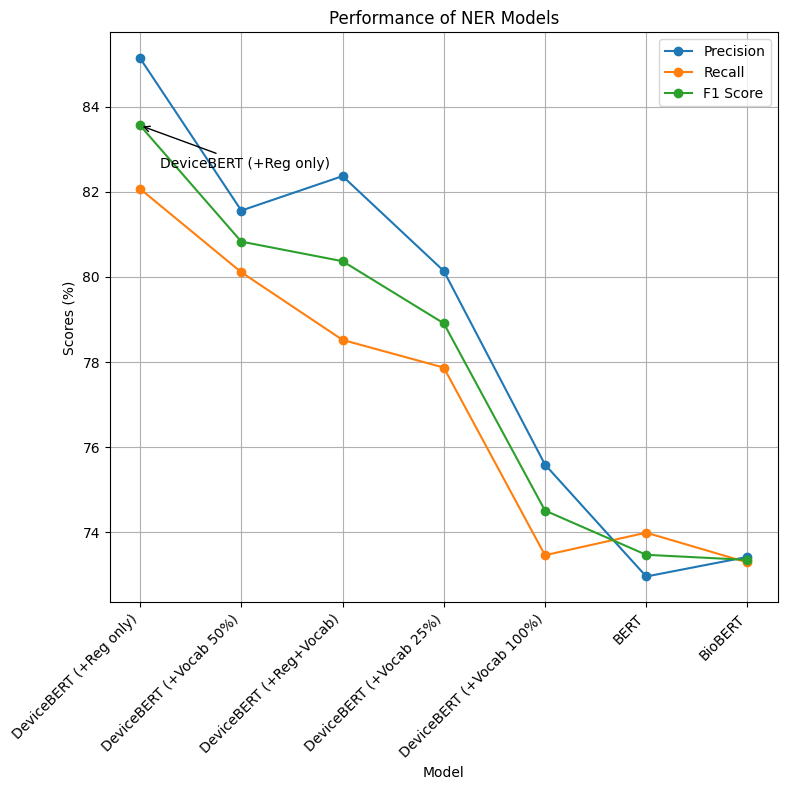

In [44]:
import matplotlib.pyplot as plt

# Define the models and their corresponding precision, recall, and F1 scores
models = ['BERT', 'BioBERT', 'DeviceBERT (+Reg only)', 'DeviceBERT (+Vocab 100%)', 'DeviceBERT (+Vocab 50%)', 'DeviceBERT (+Vocab 25%)', 'DeviceBERT (+Reg+Vocab)']
precision = [72.96, 73.42, 85.14, 75.59, 81.56, 80.14, 82.37]
recall = [73.99, 73.29, 82.07, 73.46, 80.11, 77.87, 78.52]
f1_score = [73.47, 73.35, 83.56, 74.51, 80.83, 78.91, 80.37]

# Sort the models based on F1 score
sorted_indices = sorted(range(len(f1_score)), key=lambda i: f1_score[i], reverse=True)
models_sorted = [models[i] for i in sorted_indices]
precision_sorted = [precision[i] for i in sorted_indices]
recall_sorted = [recall[i] for i in sorted_indices]
f1_score_sorted = [f1_score[i] for i in sorted_indices]

# Highlighting the best performing model's text in red
best_model_index = f1_score_sorted.index(max(f1_score_sorted))
best_model = models_sorted[best_model_index]

plt.figure(figsize=(8, 8))

# Plotting precision, recall, and F1 score
plt.plot(range(len(models_sorted)), precision_sorted, marker='o', linestyle='-', label='Precision')
plt.plot(range(len(models_sorted)), recall_sorted, marker='o', linestyle='-', label='Recall')
plt.plot(range(len(models_sorted)), f1_score_sorted, marker='o', linestyle='-', label='F1 Score')

# Annotate the best performing model with red color
plt.annotate(best_model, xy=(best_model_index, f1_score_sorted[best_model_index]),
             xytext=(best_model_index + 0.2, f1_score_sorted[best_model_index] - 1),
             arrowprops=dict(facecolor='red', arrowstyle='->'))

# Set x-ticks as model names
plt.xticks(range(len(models_sorted)), models_sorted, rotation=45, ha='right')

# Set labels and title
plt.ylabel('Scores (%)')
plt.xlabel('Model')
plt.title('Performance of NER Models')

# Set legend
plt.legend()

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()
